In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import interpolate

# Creating final dataset
df = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Time series features data
tsfeat = pd.read_csv('../data/ciao.csv')
tsfeat=tsfeat.dropna(axis=1) # delete NaN columns
tsfeat = tsfeat.drop('Unnamed: 0', axis=1)
tsfeat = tsfeat.loc[:,~tsfeat.columns.str.startswith('3_')]

i = 0
for filename in os.listdir('../data/Train2'):
    df.append(pd.read_csv(os.path.join('../data/Train2',filename),header = None, names = ['x','y','z','time']))
    i = i + 1    

data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,2,2,2,3,3]) # Classificazione richiesta con 3 classi (moving,falling,other)
#data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8]) # Classificazione con 8 classi

In [2]:
v_max = []
v_min = []
for i in range(len(df)):
    v_max.append(np.max(np.diff(df[i]['time'])))
    v_min.append(np.min(np.diff(df[i]['time'])))

print(np.max(v_max))
print(np.min(v_min)) # Problema con qualche serie temporale in cui i tempi vengono presi male, si potrebbero togliere e trattare come outliers

0.6200000000000045
0.0


In [3]:
def pre_process_data(data_acc, fs):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    data_act_acc = np.array(data_act_acc)
    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # concatenate interpolated data
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

In [4]:
df_resampled = df.copy()
for i in range(len(df)):
    df_resampled[i] = pre_process_data(df[i], 200)

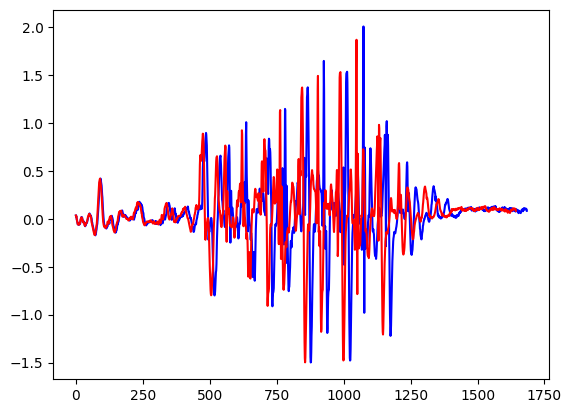

In [5]:
# Plot example
ind = 20
plt.plot(df[ind]['x'], color = 'b')
plt.plot(df_resampled[ind]['x'], color = 'r')

In [6]:
df_resampled[ind].head()

,x,y,z,time
0,0.034048,1.004600,0.173900,0.000000
1,0.023027,1.024312,0.138692,0.005005
2,0.026632,1.036261,0.150801,0.010010
3,-0.001721,1.067666,0.156465,0.015015
4,-0.016859,1.055854,0.124125,0.020019


In [7]:
df[ind].head()

,x,y,z,time
0,0.034048,1.0046,0.17390,24.277
1,0.023023,1.0243,0.13868,24.282
2,0.026687,1.0362,0.15079,24.287
3,-0.001676,1.0677,0.15656,24.292
4,-0.016814,1.0559,0.12419,24.297


In [8]:
df[ind]['time'][2]-df[ind]['time'][1]

0.004999999999999005

In [9]:
df_resampled[ind]['time'][2]-df_resampled[ind]['time'][1]

0.005004869141813755

No missing data at all

In [10]:
np.where(pd.isna(df)==True)

(array([], dtype=int64),)

# Functional outliers

In [11]:
def pre_process_data(data_acc, n_points):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int(n_points))

    data_act_acc = np.array(data_act_acc)
    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # concatenate interpolated data
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

In [12]:
from skfda import exploratory as fd_expl
fd_expl.outliers.BoxplotOutlierDetector(df_resampled[ind]['x'])

TypeError: BoxplotOutlierDetector.__init__() takes 1 positional argument but 2 were given

In [15]:
max([len(df[i]) for i in range(len(df))])

5146